python serve_vllm.py --mode server --host 0.0.0.0 --port 8000  &
cd report_agent

python generate_report.py --year 2024 --month 8 --llm-url http://localhost:8000

In [33]:
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

In [34]:
import sqlite3

db_path = '/root/De-Qwen-SFT/report_agent/demand_data/demand.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

for table in tables:
    table_name = table[0]
    print(f"\n=== Table: {table_name} 구조 ===")
    
    # 핵심 명령어: PRAGMA table_info(테이블이름)
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    
    # 컬럼 정보 예쁘게 출력
    # 결과 포맷: (cid, name, type, notnull, dflt_value, pk)
    print(f"{'CID':<5} {'Name':<20} {'Type':<10} {'NotNull':<10} {'PK':<5}")
    print("-" * 60)
    for col in columns:
        print(f"{col[0]:<5} {col[1]:<20} {col[2]:<10} {col[3]:<10} {col[5]:<5}")

conn.close()



=== Table: demand_5min 구조 ===
CID   Name                 Type       NotNull    PK   
------------------------------------------------------------
0     id                   INTEGER    1          1    
1     timestamp            DATETIME   1          0    
2     current_demand       FLOAT      0          0    
3     current_supply       FLOAT      0          0    
4     supply_capacity      FLOAT      0          0    
5     supply_reserve       FLOAT      0          0    
6     reserve_rate         FLOAT      0          0    
7     operation_reserve    FLOAT      0          0    
8     is_holiday           BOOLEAN    0          0    
9     day_type             INTEGER    0          0    

=== Table: demand_1hour 구조 ===
CID   Name                 Type       NotNull    PK   
------------------------------------------------------------
0     id                   INTEGER    1          1    
1     timestamp            DATETIME   1          0    
2     demand_mean          FLOAT      0      

In [35]:
import sqlite3
import pandas as pd

db_path = '/root/De-Qwen-SFT/report_agent/demand_data/demand.db'

# 1. DB 연결
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# 2. 'demand_1hour' 테이블의 상세 구조 조회
print(f"=== 'demand_1hour' 테이블 스키마 정보 ===")
cursor.execute("PRAGMA table_info(demand_1hour)")
columns = cursor.fetchall()

# 4. 실제 데이터 3줄만 뽑아서 눈으로 확인 (데이터 생김새 확인용)
print("\n=== 실제 데이터 미리보기 (상위 3행) ===")
df = pd.read_sql("SELECT * FROM demand_1hour", conn)
print(df)

conn.close()

=== 'demand_1hour' 테이블 스키마 정보 ===

=== 실제 데이터 미리보기 (상위 3행) ===
            id                   timestamp   demand_mean  demand_max  \
0            1  2014-01-01 00:00:00.000000  57643.686667    58986.67   
1            2  2014-01-01 01:00:00.000000  55016.895000    56146.17   
2            3  2014-01-01 02:00:00.000000  53056.093333    53861.62   
3            4  2014-01-01 03:00:00.000000  52381.716667    52615.74   
4            5  2014-01-01 04:00:00.000000  52578.280833    52818.90   
...        ...                         ...           ...         ...   
104946  104947  2025-12-23 21:00:00.000000  70319.341667    71310.40   
104947  104948  2025-12-23 22:00:00.000000  69553.150000    69966.60   
104948  104949  2025-12-23 23:00:00.000000  68263.508333    69397.50   
104949  104950  2025-12-24 00:00:00.000000  64479.125000    66174.70   
104950  104951  2025-12-24 01:00:00.000000  62427.620000    62799.80   

        demand_min    supply_mean  supply_max  supply_min  reserve_mean 

In [36]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

##  ARIMA 모델 & Holt Winter 모형 생성
- 요청한 해당월에 대한 주차별 최대부하 예측
- 최근 5개년 실적 및 전망 부분에 요청한 월 전력수요 예측 값 생성

### 주차별 Holt winter model 생성

In [37]:
# df.set_index("timestamp", inplace=True)
df.drop("id", axis=1, inplace=True)

In [38]:
df

,timestamp,demand_mean,demand_max,demand_min,supply_mean,supply_max,supply_min,reserve_mean,reserve_max,reserve_min,reserve_rate_mean,reserve_rate_max,reserve_rate_min,op_reserve_mean,op_reserve_max,op_reserve_min,is_holiday,day_type
0,2014-01-01 00:00:00,57643.686667,58986.67,56285.93,80960.000000,80960.0,80960.0,23316.313333,24674.07,21973.33,40.485509,43.83701,37.25135,15641.313333,16999.07,14298.33,1,2
1,2014-01-01 01:00:00,55016.895000,56146.17,54017.19,80960.000000,80960.0,80960.0,25943.105000,26942.81,24813.83,47.179183,49.87821,44.19506,18268.105000,19267.81,17138.83,1,2
2,2014-01-01 02:00:00,53056.093333,53861.62,52372.28,80960.000000,80960.0,80960.0,27903.907500,28587.72,27098.38,52.604723,54.58559,50.31111,20228.907500,20912.72,19423.38,1,2
3,2014-01-01 03:00:00,52381.716667,52615.74,52184.87,80958.000000,80960.0,80957.0,28576.283333,28772.13,28344.26,54.554968,55.13500,53.87032,20903.283333,21100.13,20669.26,1,2
4,2014-01-01 04:00:00,52578.280833,52818.90,52316.79,80957.000000,80957.0,80957.0,28378.719167,28640.21,28138.10,53.976000,54.74381,53.27279,20706.719167,20968.21,20466.10,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104946,2025-12-23 21:00:00,70319.341667,71310.40,69336.60,102372.083333,102478.0,102289.0,32052.900000,32952.70,31123.90,45.592525,47.52570,43.64560,14447.175000,14933.20,13969.30,0,0
104947,2025-12-23 22:00:00,69553.150000,69966.60,68793.70,102076.166667,102433.0,101968.0,32523.125000,33241.80,32118.30,46.763742,48.32100,45.90510,12699.166667,14851.20,12117.40,0,0
104948,2025-12-23 23:00:00,68263.508333,69397.50,66581.00,101838.666667,102007.0,101749.0,33575.175000,35198.90,32557.20,49.209650,52.86630,46.91410,11478.358333,12110.40,11136.90,0,0
104949,2025-12-24 00:00:00,64479.125000,66174.70,62750.50,103054.166667,103311.0,101796.0,38575.033333,40480.20,35621.70,59.876400,64.50970,53.82970,12697.691667,13306.50,11258.90,0,0


In [39]:
# demand_mean 만 가지고 활용한다.
df1 = df[["demand_max", "is_holiday" ,"day_type", "timestamp"]]
df1.reset_index(inplace=True)

# 주차별 모델링부터 확인한다 -
df1_weekly = df1.resample('W', on='timestamp').mean()

In [40]:
# 수정된 코드 
model = ExponentialSmoothing(
    df1_weekly['demand_max'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=52 
).fit()

In [41]:
forecast_hw = model.forecast(steps=4)
print(forecast_hw)

2026-01-04    70439.021298
2026-01-11    72062.301444
2026-01-18    70185.778674
2026-01-25    69786.388971
Freq: W-SUN, dtype: float64


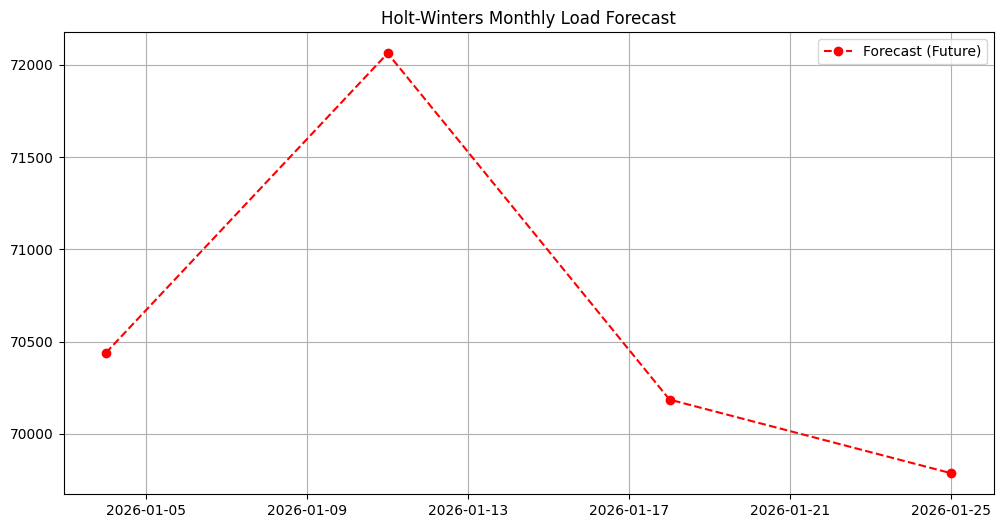

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(forecast_hw.index, forecast_hw, label='Forecast (Future)', color='red', linestyle='--', marker='o')
plt.title('Holt-Winters Monthly Load Forecast')
plt.legend()
plt.grid(True)
plt.show()

### 주차별 ARIMA 모델링


 방법 1: 기본 Direct ARIMA
>>> Direct ARIMA 학습 시작
    Order: (1, 1, 0), Forecast Steps: 4
--------------------------------------------------
  [Horizon 1] 모델 학습 중... AIC: 11882.15
  [Horizon 2] 모델 학습 중... AIC: 11882.15
  [Horizon 3] 모델 학습 중... AIC: 11882.15
  [Horizon 4] 모델 학습 중... AIC: 11882.15
--------------------------------------------------
>>> 학습 완료


=== 기본 Direct ARIMA 예측 결과 ===
  Week 1 (t+1) | 2026-01-04: 72,038.53
  Week 2 (t+2) | 2026-01-11: 72,089.16
  Week 3 (t+3) | 2026-01-18: 72,083.39
  Week 4 (t+4) | 2026-01-25: 72,084.05


 방법 2: Auto-Tune Direct ARIMA (Horizon별 최적 Order)
>>> Direct ARIMA Auto-Tune 시작
    Train: 500, Validation: 126
    Order 후보: [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 1, 0), (2, 1, 1), (0, 1, 1)]

[Horizon 1] 최적 order 탐색...
    (1, 0, 0): AIC=9434.10, Score=17123.90
    (1, 1, 0): AIC=9448.56, Score=15502.24
    (1, 1, 1): AIC=9451.28, Score=15500.57
    (2, 1, 0): AIC=9450.58, Score=15505.76
    (2, 1, 1): AIC=9451.32, Score=16090.44
    (0, 1, 1): AIC=

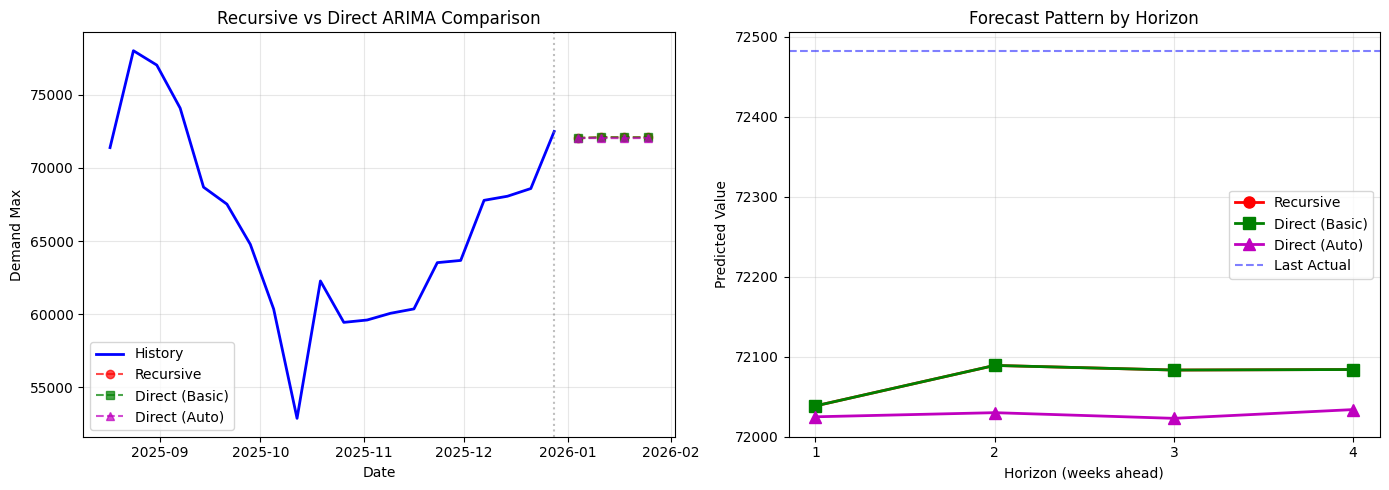


>>> 그래프 저장: direct_vs_recursive_arima.png

 결론: Recursive vs Direct 차이

┌─────────────────┬──────────────────────────────────────────────────┐
│     방식        │                    특징                          │
├─────────────────┼──────────────────────────────────────────────────┤
│   Recursive     │ • 예측값 → 다음 입력 (오차 누적)                 │
│                 │ • 멀리 갈수록 평균으로 수렴 (평평해짐)           │
│                 │ • 변동성 감소                                    │
├─────────────────┼──────────────────────────────────────────────────┤
│   Direct        │ • 각 horizon 독립 예측 (오차 누적 없음)          │
│                 │ • 실제 변동성에 더 가까움                        │
│                 │ • horizon별 최적화 가능                          │
└─────────────────┴──────────────────────────────────────────────────┘

Direct가 더 좋은 경우:
  - 긴 예측 구간 (4주 이상)
  - 변동성이 큰 데이터
  - 각 시점별 정확도가 중요할 때

Recursive가 더 좋은 경우:
  - 짧은 예측 구간 (1-2주)
  - 추세 연속성이 중요할 때



In [43]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# Direct Multi-step Forecasting with ARIMA
# ==========================================
# 핵심 아이디어:
# - Recursive: 1개 모델이 t+1 예측 → 그 값으로 t+2 예측 → ... (오차 누적)
# - Direct: t+1용 모델, t+2용 모델, t+3용 모델, t+4용 모델 각각 학습 (독립적)

# ==========================================
# 1. Direct 학습용 데이터셋 생성
# ==========================================
def create_direct_dataset(series, n_input, horizon):
    """
    특정 horizon에 대한 Direct 학습 데이터 생성
    
    Args:
        series: 시계열 데이터 (array)
        n_input: 입력 윈도우 크기
        horizon: 몇 스텝 뒤를 예측할지 (1, 2, 3, 4)
    
    Returns:
        X: 입력 데이터 (과거 n_input개)
        y: 타겟 데이터 (horizon 스텝 뒤 값)
    
    Example (n_input=3, horizon=2):
        X: [t-2, t-1, t]  →  y: t+2
        X: [t-1, t, t+1]  →  y: t+3
    """
    X, y = [], []
    for i in range(len(series) - n_input - horizon + 1):
        X.append(series[i:i + n_input])
        y.append(series[i + n_input + horizon - 1])  # horizon 스텝 뒤
    return np.array(X), np.array(y)


# ==========================================
# 2. Direct ARIMA 클래스
# ==========================================
class DirectARIMA:
    """
    Direct Multi-step ARIMA
    - 각 forecast horizon별로 독립적인 ARIMA 모델 학습
    - t+1, t+2, t+3, t+4 각각 별도 모델
    """
    
    def __init__(self, order=(1, 1, 0), forecast_steps=4):
        self.order = order
        self.forecast_steps = forecast_steps
        self.models = {}  # horizon별 모델 저장
        self.fitted_models = {}
        
    def fit(self, series):
        """
        각 horizon별로 ARIMA 모델 학습
        
        Args:
            series: 학습용 시계열 데이터
        """
        print(f">>> Direct ARIMA 학습 시작")
        print(f"    Order: {self.order}, Forecast Steps: {self.forecast_steps}")
        print("-" * 50)
        
        for h in range(1, self.forecast_steps + 1):
            print(f"  [Horizon {h}] 모델 학습 중...", end=" ")
            
            # 해당 horizon에 맞는 타겟으로 ARIMA 학습
            # ARIMA는 직접 horizon을 지정할 수 없으므로,
            # 전체 시계열로 학습 후 forecast(steps=h)로 예측
            model = ARIMA(series, order=self.order)
            fitted = model.fit()
            
            self.models[h] = model
            self.fitted_models[h] = fitted
            
            print(f"AIC: {fitted.aic:.2f}")
        
        print("-" * 50)
        print(">>> 학습 완료\n")
        
    def predict(self, series=None):
        """
        미래 forecast_steps 만큼 예측 (각 horizon 독립적으로)
        
        Returns:
            predictions: 각 horizon별 예측값 리스트
        """
        predictions = []
        
        for h in range(1, self.forecast_steps + 1):
            # 각 모델이 자신의 horizon만큼 앞을 예측
            # forecast(steps=h)의 마지막 값이 t+h 예측
            forecast = self.fitted_models[h].forecast(steps=h)
            pred_value = forecast.iloc[-1] if hasattr(forecast, 'iloc') else forecast[-1]
            predictions.append(pred_value)
            
        return np.array(predictions)
    
    def predict_with_update(self, series):
        """
        최신 데이터로 모델 업데이트 후 예측
        (Expanding Window 방식과 결합)
        
        Args:
            series: 최신 시계열 데이터
            
        Returns:
            predictions: 각 horizon별 예측값
        """
        predictions = []
        
        print(">>> 최신 데이터로 모델 업데이트 & 예측")
        print("-" * 50)
        
        for h in range(1, self.forecast_steps + 1):
            # 최신 데이터로 재학습
            model = ARIMA(series, order=self.order)
            fitted = model.fit()
            
            # h 스텝 뒤 예측
            forecast = fitted.forecast(steps=h)
            pred_value = forecast.iloc[-1] if hasattr(forecast, 'iloc') else forecast[-1]
            predictions.append(pred_value)
            
            print(f"  [Horizon {h}] 예측값: {pred_value:.2f}")
        
        print("-" * 50)
        return np.array(predictions)


# ==========================================
# 3. 개선된 Direct ARIMA (Horizon별 최적 Order)
# ==========================================
class DirectARIMAAutoTune:
    """
    각 Horizon별로 최적의 ARIMA order를 자동 탐색
    - 짧은 horizon: 단순 모델이 좋을 수 있음
    - 긴 horizon: 더 복잡한 모델이 필요할 수 있음
    """
    
    def __init__(self, forecast_steps=4, order_candidates=None):
        self.forecast_steps = forecast_steps
        self.order_candidates = order_candidates or [
            (1, 0, 0), (1, 1, 0), (1, 1, 1),
            (2, 1, 0), (2, 1, 1), (0, 1, 1)
        ]
        self.best_orders = {}
        self.fitted_models = {}
        
    def fit(self, series, validation_split=0.2):
        """
        각 horizon별 최적 order 탐색 후 학습
        """
        n = len(series)
        train_size = int(n * (1 - validation_split))
        train = series[:train_size]
        val = series[train_size:]
        
        print(f">>> Direct ARIMA Auto-Tune 시작")
        print(f"    Train: {train_size}, Validation: {len(val)}")
        print(f"    Order 후보: {self.order_candidates}")
        print("=" * 60)
        
        for h in range(1, self.forecast_steps + 1):
            print(f"\n[Horizon {h}] 최적 order 탐색...")
            
            best_aic = float('inf')
            best_order = None
            
            for order in self.order_candidates:
                try:
                    model = ARIMA(train, order=order)
                    fitted = model.fit()
                    
                    # Validation: h 스텝 뒤 예측 정확도
                    if len(val) >= h:
                        forecast = fitted.forecast(steps=h)
                        pred = forecast.iloc[-1] if hasattr(forecast, 'iloc') else forecast[-1]
                        actual = val[h - 1]
                        error = abs(pred - actual)
                        
                        # AIC + Validation Error 조합
                        score = fitted.aic + error * 10
                    else:
                        score = fitted.aic
                    
                    if score < best_aic:
                        best_aic = score
                        best_order = order
                        
                    print(f"    {order}: AIC={fitted.aic:.2f}, Score={score:.2f}")
                    
                except Exception as e:
                    print(f"    {order}: 실패 - {str(e)[:30]}")
                    continue
            
            self.best_orders[h] = best_order
            print(f"  → Best Order for h={h}: {best_order}")
        
        # 최적 order로 전체 데이터 재학습
        print("\n" + "=" * 60)
        print(">>> 최적 order로 전체 데이터 학습")
        
        for h in range(1, self.forecast_steps + 1):
            order = self.best_orders[h]
            model = ARIMA(series, order=order)
            self.fitted_models[h] = model.fit()
            print(f"  [Horizon {h}] Order {order} 학습 완료")
        
        print("=" * 60)
        
    def predict(self):
        """각 horizon별 예측"""
        predictions = []
        
        for h in range(1, self.forecast_steps + 1):
            forecast = self.fitted_models[h].forecast(steps=h)
            pred = forecast.iloc[-1] if hasattr(forecast, 'iloc') else forecast[-1]
            predictions.append(pred)
            
        return np.array(predictions)


# ==========================================
# 4. 실행: 기본 Direct ARIMA
# ==========================================
print("\n" + "=" * 70)
print(" 방법 1: 기본 Direct ARIMA")
print("=" * 70)

# 데이터 준비
series = df1_weekly['demand_max'].values
last_date = df1_weekly.index[-1]

# Direct ARIMA 학습 및 예측
direct_model = DirectARIMA(order=(1, 1, 0), forecast_steps=4)
direct_model.fit(series)
predictions_basic = direct_model.predict()

# 결과 출력
future_dates = pd.date_range(start=last_date, periods=5, freq='W')[1:]

print("\n=== 기본 Direct ARIMA 예측 결과 ===")
for i, (date, val) in enumerate(zip(future_dates, predictions_basic)):
    print(f"  Week {i+1} (t+{i+1}) | {date.date()}: {val:,.2f}")


# ==========================================
# 5. 실행: Auto-Tune Direct ARIMA
# ==========================================
print("\n\n" + "=" * 70)
print(" 방법 2: Auto-Tune Direct ARIMA (Horizon별 최적 Order)")
print("=" * 70)

# Auto-Tune 모델
auto_model = DirectARIMAAutoTune(forecast_steps=4)
auto_model.fit(series, validation_split=0.2)
predictions_auto = auto_model.predict()

# 결과 출력
print("\n=== Auto-Tune Direct ARIMA 예측 결과 ===")
print(f"각 Horizon별 최적 Order: {auto_model.best_orders}")
for i, (date, val) in enumerate(zip(future_dates, predictions_auto)):
    print(f"  Week {i+1} (t+{i+1}) | {date.date()}: {val:,.2f}")


# ==========================================
# 6. Recursive vs Direct 비교
# ==========================================
print("\n\n" + "=" * 70)
print(" 비교: Recursive vs Direct")
print("=" * 70)

# Recursive 예측 (기존 방식)
history = list(series)
predictions_recursive = []

for i in range(4):
    model = ARIMA(history, order=(1, 1, 0))
    fitted = model.fit()
    yhat = fitted.forecast()[0]
    predictions_recursive.append(yhat)
    history.append(yhat)  # 예측값을 입력으로 사용

predictions_recursive = np.array(predictions_recursive)

# 비교 테이블
print("\n=== 예측값 비교 ===")
print(f"{'Horizon':<10} {'Recursive':>15} {'Direct (Basic)':>15} {'Direct (Auto)':>15}")
print("-" * 60)
for i in range(4):
    print(f"t+{i+1:<8} {predictions_recursive[i]:>15,.2f} {predictions_basic[i]:>15,.2f} {predictions_auto[i]:>15,.2f}")

# 변동성 비교
print(f"\n=== 변동성 (표준편차) ===")
print(f"  Recursive:    {np.std(predictions_recursive):.2f}")
print(f"  Direct Basic: {np.std(predictions_basic):.2f}")
print(f"  Direct Auto:  {np.std(predictions_auto):.2f}")
print(f"  실제 최근 4주: {np.std(series[-4:]):.2f}")


# ==========================================
# 7. 시각화
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 그래프 1: 전체 비교
ax1 = axes[0]
ax1.plot(df1_weekly.index[-20:], df1_weekly['demand_max'][-20:], 
         'b-', label='History', linewidth=2)
ax1.plot(future_dates, predictions_recursive, 
         'r--o', label='Recursive', alpha=0.7)
ax1.plot(future_dates, predictions_basic, 
         'g--s', label='Direct (Basic)', alpha=0.7)
ax1.plot(future_dates, predictions_auto, 
         'm--^', label='Direct (Auto)', alpha=0.7)
ax1.axvline(x=last_date, color='gray', linestyle=':', alpha=0.5)
ax1.set_title('Recursive vs Direct ARIMA Comparison')
ax1.set_xlabel('Date')
ax1.set_ylabel('Demand Max')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 그래프 2: 예측값 변화 패턴
ax2 = axes[1]
horizons = [1, 2, 3, 4]
ax2.plot(horizons, predictions_recursive, 'r-o', label='Recursive', linewidth=2, markersize=8)
ax2.plot(horizons, predictions_basic, 'g-s', label='Direct (Basic)', linewidth=2, markersize=8)
ax2.plot(horizons, predictions_auto, 'm-^', label='Direct (Auto)', linewidth=2, markersize=8)
ax2.axhline(y=series[-1], color='blue', linestyle='--', alpha=0.5, label='Last Actual')
ax2.set_title('Forecast Pattern by Horizon')
ax2.set_xlabel('Horizon (weeks ahead)')
ax2.set_ylabel('Predicted Value')
ax2.set_xticks(horizons)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('direct_vs_recursive_arima.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n>>> 그래프 저장: direct_vs_recursive_arima.png")


# ==========================================
# 8. 결과 요약
# ==========================================
print("\n" + "=" * 70)
print(" 결론: Recursive vs Direct 차이")
print("=" * 70)
print("""
┌─────────────────┬──────────────────────────────────────────────────┐
│     방식        │                    특징                          │
├─────────────────┼──────────────────────────────────────────────────┤
│   Recursive     │ • 예측값 → 다음 입력 (오차 누적)                 │
│                 │ • 멀리 갈수록 평균으로 수렴 (평평해짐)           │
│                 │ • 변동성 감소                                    │
├─────────────────┼──────────────────────────────────────────────────┤
│   Direct        │ • 각 horizon 독립 예측 (오차 누적 없음)          │
│                 │ • 실제 변동성에 더 가까움                        │
│                 │ • horizon별 최적화 가능                          │
└─────────────────┴──────────────────────────────────────────────────┘

Direct가 더 좋은 경우:
  - 긴 예측 구간 (4주 이상)
  - 변동성이 큰 데이터
  - 각 시점별 정확도가 중요할 때

Recursive가 더 좋은 경우:
  - 짧은 예측 구간 (1-2주)
  - 추세 연속성이 중요할 때
""")

## LSTM 모델링

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import random
import pickle
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==========================================
# 0. 파일명(Weekly Max / Direct Multi-step / Non-overlap) 설정
# ==========================================
n_input = 12
n_output = 8   # 예측 horizon = 4주
tag = f"weekly_max_h{n_output}_win{n_input}"

MODEL_STATE_PATH = f"best_direct_lstm_state_{tag}.pth"
MODEL_FULL_PATH  = f"best_direct_lstm_full_{tag}.pth"
SCALER_PATH      = f"scalers_{tag}.pkl"
FORECAST_PATH    = f"forecast_results_direct_{tag}.csv"

# ==========================================
# 1. 데이터 준비 (Non-Overlap 설정)
# ==========================================
# df1_weekly: index=DatetimeIndex, columns include ["demand_max","is_holiday","day_type"]
# 예시:
# df1_weekly = pd.read_csv('your_weekly.csv', index_col=0, parse_dates=True)

required_cols = ["demand_max", "is_holiday", "day_type"]
for c in required_cols:
    if c not in df1_weekly.columns:
        raise ValueError(f"df1_weekly에 '{c}' 컬럼이 없습니다.")

if not isinstance(df1_weekly.index, pd.DatetimeIndex):
    raise ValueError("df1_weekly.index는 DatetimeIndex여야 합니다 (parse_dates=True 확인).")

df1_weekly = df1_weekly.copy()
df1_weekly[required_cols] = df1_weekly[required_cols].astype(float)
df1_weekly = df1_weekly.dropna(subset=required_cols)

scaler_x = MinMaxScaler()
data_x_scaled = scaler_x.fit_transform(df1_weekly[["demand_max", "is_holiday", "day_type"]])

scaler_y = MinMaxScaler()
data_y_scaled = scaler_y.fit_transform(df1_weekly[["demand_max"]])

n_features = 3

def create_dataset_non_overlap(data_x, data_y, n_input, n_output):
    """
    Non-overlap 방식
    - step을 n_output으로 설정해, 타겟 구간이 겹치지 않게 생성
    """
    X, y = [], []
    for i in range(0, len(data_x) - n_input - n_output + 1, n_output):
        X.append(data_x[i:(i + n_input)])
        y.append(data_y[(i + n_input):(i + n_input + n_output)])  # (n_output, 1)
    return np.array(X), np.array(y)

X_all, y_all = create_dataset_non_overlap(data_x_scaled, data_y_scaled, n_input, n_output)

print(f"=== 데이터셋 정보 ===")
print(f"총 샘플 개수: {len(X_all)}")
print(f"X shape: {X_all.shape}, y shape: {y_all.shape}")

if len(X_all) < 5:
    raise ValueError("샘플 수가 너무 적습니다. 데이터 길이/n_input/n_output 확인 필요.")

# 80/20 split (시계열이므로 순서 유지)
train_size = int(len(X_all) * 0.8)
X_train, X_val = X_all[:train_size], X_all[train_size:]
y_train, y_val = y_all[:train_size], y_all[train_size:]

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)

print(f"학습 샘플: {len(X_train)}, 검증 샘플: {len(X_val)}")

# ==========================================
# 2. 모델 정의 (Direct Multi-step Forecasting)
# ==========================================
class DirectLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1, forecast_steps=4):
        super(DirectLSTM, self).__init__()
        self.encoder = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1 if num_layers > 1 else 0
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, forecast_steps)
        )

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        last_hidden = hidden[-1]               # (batch, hidden)
        out = self.fc(last_hidden)             # (batch, forecast_steps)
        return out.unsqueeze(-1)               # (batch, forecast_steps, 1)

class DirectLSTMWithAttention(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1, forecast_steps=4):
        super(DirectLSTMWithAttention, self).__init__()
        self.encoder = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1 if num_layers > 1 else 0
        )
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, forecast_steps)
        )

    def forward(self, x):
        encoder_output, _ = self.encoder(x)               # (batch, seq, hidden)
        attn_scores = self.attention(encoder_output)      # (batch, seq, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)  # (batch, seq, 1)
        context = torch.sum(encoder_output * attn_weights, dim=1)  # (batch, hidden)
        out = self.fc(context)                            # (batch, forecast_steps)
        return out.unsqueeze(-1)                          # (batch, forecast_steps, 1)

# ==========================================
# 3. 랜덤 서치
# ==========================================
param_dist = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'learning_rate': [0.01, 0.001, 0.0005],
    'batch_size': [4, 8, 16],
    'epochs': [50, 100, 150],
    'use_attention': [True, False]
}

num_iter = 10
best_loss = float('inf')
best_model_state = None
best_params = {}

print(f"\n>>> 랜덤 서치 시작 (Direct Non-Overlap / {tag})...")
print(f">>> 총 {num_iter}회 반복\n")

for i in range(num_iter):
    params = {k: random.choice(v) for k, v in param_dist.items()}

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        drop_last=False
    )

    if params['use_attention']:
        model = DirectLSTMWithAttention(
            input_size=n_features,
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            forecast_steps=n_output
        ).to(device)
    else:
        model = DirectLSTM(
            input_size=n_features,
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            forecast_steps=n_output
        ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    model.train()
    for epoch in range(params['epochs']):
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = criterion(pred, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step(epoch_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor).item()

    model_type = "Attention" if params['use_attention'] else "Basic"
    print(f"[{i+1:2d}/{num_iter}] {model_type:9s} | "
          f"H={params['hidden_size']:3d}, L={params['num_layers']}, "
          f"LR={params['learning_rate']:.4f}, B={params['batch_size']:2d}, "
          f"E={params['epochs']:3d} | Val Loss: {val_loss:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params
        best_model_state = copy.deepcopy(model.state_dict())
        print("         ↳ 새로운 최적 모델!")

# ==========================================
# 4. 결과 출력 및 저장 (파일명 분리)
# ==========================================
print("\n" + "="*60)
print(">>> 최적 파라미터:")
for k, v in best_params.items():
    print(f"    {k}: {v}")
print(f">>> 최적 Validation Loss: {best_loss:.6f}")
print("="*60)

# state / full 파일 분리 저장(덮어쓰기 방지)
torch.save(best_model_state, MODEL_STATE_PATH)
torch.save({
    'model_state': best_model_state,
    'params': best_params,
    'val_loss': best_loss,
    'n_input': n_input,
    'n_output': n_output,
    'feature_cols': ["demand_max", "is_holiday", "day_type"],
    'target_col': "demand_max",
    'tag': tag
}, MODEL_FULL_PATH)

with open(SCALER_PATH, 'wb') as f:
    pickle.dump({'scaler_x': scaler_x, 'scaler_y': scaler_y}, f)

print("\n>>> 모델 및 스케일러 저장 완료.")
print(f" - model_state: {MODEL_STATE_PATH}")
print(f" - model_full : {MODEL_FULL_PATH}")
print(f" - scalers    : {SCALER_PATH}")

# ==========================================
# 5. 추론 (미래 4주 예측)
# ==========================================
# 최적 모델 구성
if best_params['use_attention']:
    loaded_model = DirectLSTMWithAttention(
        input_size=n_features,
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        forecast_steps=n_output
    ).to(device)
else:
    loaded_model = DirectLSTM(
        input_size=n_features,
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        forecast_steps=n_output
    ).to(device)

loaded_model.load_state_dict(best_model_state)
loaded_model.eval()

# 마지막 시퀀스로 예측
last_sequence_x = data_x_scaled[-n_input:]
last_sequence_tensor = torch.FloatTensor(last_sequence_x).unsqueeze(0).to(device)

with torch.no_grad():
    forecast_scaled = loaded_model(last_sequence_tensor).cpu().numpy()  # (1,4,1)

# 스케일러 로드(파일명 일치)
with open(SCALER_PATH, 'rb') as f:
    scalers = pickle.load(f)
loaded_scaler_y = scalers['scaler_y']

# (1,4,1) -> (4,1) 로 inverse_transform
forecast = loaded_scaler_y.inverse_transform(forecast_scaled[0])

print("\n" + "="*60)
print("=== [Direct Non-Overlap] 최종 예측 결과 (Weekly Max, 4-step) ===")
print("="*60)

# 날짜 생성: df1_weekly 기준으로 일관
last_date = df1_weekly.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_output + 1, freq='W')[1:]

results = []
for i, (date, val) in enumerate(zip(future_dates, forecast)):
    print(f"  Week {i+1} ({date.date()}): {val[0]:,.2f}")
    results.append({'date': date, 'forecast': float(val[0])})

forecast_df = pd.DataFrame(results)
forecast_df.to_csv(FORECAST_PATH, index=False)
print(f"\n>>> 예측 결과 저장: {FORECAST_PATH}")


Using device: cuda
=== 데이터셋 정보 ===
총 샘플 개수: 76
X shape: (76, 12, 3), y shape: (76, 8, 1)
학습 샘플: 60, 검증 샘플: 16

>>> 랜덤 서치 시작 (Direct Non-Overlap / weekly_max_h8_win12)...
>>> 총 10회 반복



[ 1/10] Attention | H= 32, L=2, LR=0.0100, B=16, E= 50 | Val Loss: 0.037940
         ↳ 새로운 최적 모델!
[ 2/10] Basic     | H=128, L=2, LR=0.0005, B= 4, E=100 | Val Loss: 0.021333
         ↳ 새로운 최적 모델!
[ 3/10] Basic     | H= 32, L=1, LR=0.0005, B= 8, E=100 | Val Loss: 0.048544
[ 4/10] Attention | H= 64, L=2, LR=0.0100, B= 4, E= 50 | Val Loss: 0.054060
[ 5/10] Attention | H= 64, L=1, LR=0.0005, B=16, E= 50 | Val Loss: 0.049999
[ 6/10] Attention | H= 32, L=1, LR=0.0005, B=16, E= 50 | Val Loss: 0.053514
[ 7/10] Attention | H= 32, L=1, LR=0.0010, B= 4, E=150 | Val Loss: 0.030696
[ 8/10] Basic     | H= 64, L=2, LR=0.0100, B=16, E= 50 | Val Loss: 0.021801
[ 9/10] Attention | H= 32, L=2, LR=0.0010, B= 4, E= 50 | Val Loss: 0.042590
[10/10] Basic     | H=128, L=2, LR=0.0010, B= 8, E=100 | Val Loss: 0.019762
         ↳ 새로운 최적 모델!

>>> 최적 파라미터:
    hidden_size: 128
    num_layers: 2
    learning_rate: 0.001
    batch_size: 8
    epochs: 100
    use_attention: False
>>> 최적 Validation Loss: 0.019762

>>>

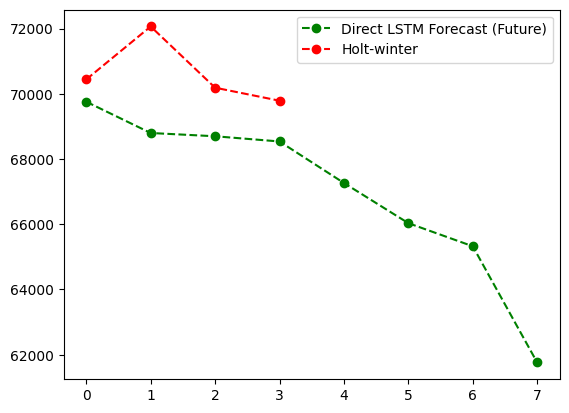

In [46]:
plt.plot(forecast_df["forecast"].values, label = "Direct LSTM Forecast (Future)", color='green', linestyle='--', marker='o')
# plt.plot(forecast_arima.values, label = 'arima Forecast (Future)', color='blue', linestyle='--', marker='o')
plt.plot(forecast_hw.values, label = 'Holt-winter', color='red', linestyle='--', marker='o')
plt.legend()

# mean load 생성

In [9]:
# demand_mean 만 가지고 활용한다.
df2 = df[["demand_mean", "is_holiday" ,"day_type", "timestamp"]]
df2.reset_index(inplace=True)

# 월별 모델링 시작한다.
df2_monthly = df2.resample('M', on='timestamp').mean()

/tmp/ipykernel_4520/4094230645.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2_monthly = df2.resample('M', on='timestamp').mean()


In [11]:
df2_monthly.drop("index", axis=1, inplace=True)

### 월별 monthly 데이터 예측기 [여기서 해야 하는건 평균이랑 peak 둘다 잡아야 하는거임.]
- ARIMA
- Holt-Winter
- LSTM

* 이후 평균내서 전망결과 table에 반영한다.

#### 평균부하 예측기

In [15]:
# 수정된 코드 
model_monthly = ExponentialSmoothing(
    df2_monthly['demand_mean'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12
).fit()

# 예측
forecast_hw_month = model.forecast(steps=1)
print(forecast_hw_month)

2026-01-31    69544.676206
Freq: ME, dtype: float64


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import random
import pickle
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==========================================
# 1. 데이터 준비 (Many-to-One, Window=12) - 월간 평균부하
# ==========================================
scaler_x = MinMaxScaler()
data_x_scaled = scaler_x.fit_transform(df2_monthly[["demand_mean", "is_holiday", "day_type"]])

scaler_y = MinMaxScaler()
data_y_scaled = scaler_y.fit_transform(df2_monthly[["demand_mean"]])

n_input = 12
n_output = 1
n_features = 3

def create_dataset_many2one(data_x, data_y, n_input, stride=1):
    X, y = [], []
    for i in range(0, len(data_x) - n_input, stride):
        X.append(data_x[i:(i + n_input)])
        y.append(data_y[i + n_input])  # 1-step
    return np.array(X), np.array(y)

stride = 1
X_all, y_all = create_dataset_many2one(data_x_scaled, data_y_scaled, n_input, stride=stride)

print(f"=== 데이터셋 정보 ===")
print(f"총 샘플 개수: {len(X_all)}")
print(f"X shape: {X_all.shape}, y shape: {y_all.shape}")

train_size = int(len(X_all) * 0.8)
X_train, X_val = X_all[:train_size], X_all[train_size:]
y_train, y_val = y_all[:train_size], y_all[train_size:]

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)

print(f"학습 샘플: {len(X_train)}, 검증 샘플: {len(X_val)}")

# ==========================================
# 2. 모델 정의
# ==========================================
class Many2OneLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1):
        super(Many2OneLSTM, self).__init__()
        self.encoder = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1 if num_layers > 1 else 0
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        last_hidden = hidden[-1]
        out = self.fc(last_hidden)
        return out.unsqueeze(1)  # (batch,1,1)

class Many2OneLSTMWithAttention(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1):
        super(Many2OneLSTMWithAttention, self).__init__()
        self.encoder = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1 if num_layers > 1 else 0
        )
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        encoder_output, _ = self.encoder(x)              # (batch,seq,hidden)
        attn_scores = self.attention(encoder_output)     # (batch,seq,1)
        attn_weights = torch.softmax(attn_scores, dim=1) # (batch,seq,1)
        context = torch.sum(encoder_output * attn_weights, dim=1)
        out = self.fc(context)
        return out.unsqueeze(1)                          # (batch,1,1)

# ==========================================
# 3. 랜덤 서치
# ==========================================
param_dist = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'learning_rate': [0.01, 0.001, 0.0005],
    'batch_size': [4, 8, 16],
    'epochs': [50, 100, 150],
    'use_attention': [True, False]
}

num_iter = 10
best_loss = float('inf')
best_model_state = None
best_params = {}

print(f"\n>>> 랜덤 서치 시작 (Many-to-One, Window=12, Monthly Mean)...")
print(f">>> 총 {num_iter}회 반복\n")

for i in range(num_iter):
    params = {k: random.choice(v) for k, v in param_dist.items()}

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor.unsqueeze(1))  # (N,1,1)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, drop_last=False)

    if params['use_attention']:
        model = Many2OneLSTMWithAttention(
            input_size=n_features,
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers']
        ).to(device)
    else:
        model = Many2OneLSTM(
            input_size=n_features,
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers']
        ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    model.train()
    for epoch in range(params['epochs']):
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = criterion(pred, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step(epoch_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_target = y_val_tensor.unsqueeze(1)
        val_loss = criterion(val_pred, val_target).item()

    model_type = "Attention" if params['use_attention'] else "Basic"
    print(f"[{i+1:2d}/{num_iter}] {model_type:9s} | "
          f"H={params['hidden_size']:3d}, L={params['num_layers']}, "
          f"LR={params['learning_rate']:.4f}, B={params['batch_size']:2d}, "
          f"E={params['epochs']:3d} | Val Loss: {val_loss:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params
        best_model_state = copy.deepcopy(model.state_dict())
        print("         ↳ 새로운 최적 모델!")

# ==========================================
# 4. 결과 출력 및 저장 (파일명 정리: Monthly Mean)
# ==========================================
print("\n" + "="*60)
print(">>> 최적 파라미터:")
for k, v in best_params.items():
    print(f"    {k}: {v}")
print(f">>> 최적 Validation Loss: {best_loss:.6f}")
print("="*60)

# [핵심] 평균부하용 파일명으로 분리
model_state_path = f'best_many2one_lstm_state_monthly_mean_win{n_input}.pth'
model_full_path  = f'best_many2one_lstm_full_monthly_mean_win{n_input}.pth'
scaler_path      = 'scalers_monthly_mean.pkl'
forecast_path    = 'forecast_results_many2one_monthly_mean.csv'

# state / full 분리 저장 (덮어쓰기 방지)
torch.save(best_model_state, model_state_path)
torch.save({
    'model_state': best_model_state,
    'params': best_params,
    'val_loss': best_loss,
    'n_input': n_input,
    'n_output': n_output,
    'stride': stride,
    'feature_cols': ["demand_mean", "is_holiday", "day_type"],
    'target_col': "demand_mean"
}, model_full_path)

with open(scaler_path, 'wb') as f:
    pickle.dump({'scaler_x': scaler_x, 'scaler_y': scaler_y}, f)

print("\n>>> 모델 및 스케일러 저장 완료.")
print(f" - model_state: {model_state_path}")
print(f" - model_full : {model_full_path}")
print(f" - scalers    : {scaler_path}")

# ==========================================
# 5. 추론 (다음 1개월 예측: Many-to-One)
# ==========================================
# 모델 구성
if best_params['use_attention']:
    loaded_model = Many2OneLSTMWithAttention(
        input_size=n_features,
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers']
    ).to(device)
else:
    loaded_model = Many2OneLSTM(
        input_size=n_features,
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers']
    ).to(device)

loaded_model.load_state_dict(best_model_state)
loaded_model.eval()

# 마지막 12개로 예측
last_sequence_x = data_x_scaled[-n_input:]
last_sequence_tensor = torch.FloatTensor(last_sequence_x).unsqueeze(0).to(device)

with torch.no_grad():
    forecast_scaled = loaded_model(last_sequence_tensor).cpu().numpy()  # (1,1,1)

# [핵심] 평균부하용 scaler 파일 로드
with open(scaler_path, 'rb') as f:
    scalers = pickle.load(f)
loaded_scaler_y = scalers['scaler_y']

forecast_value = loaded_scaler_y.inverse_transform(forecast_scaled.reshape(1, 1))[0, 0]

print("\n" + "="*60)
print("=== [Many-to-One] 최종 예측 결과 (Next 1 Period, Monthly Mean) ===")
print("="*60)

# 월간 index에 맞게 freq 설정
# 월말 집계면 'M', 월초 집계면 'MS'
USE_MONTH_START = False  # 월초 인덱스면 True로 변경
freq = 'MS' if USE_MONTH_START else 'M'

last_date = df2_monthly.index[-1]
next_date = pd.date_range(start=last_date, periods=2, freq=freq)[1]

print(f"  Next Period ({next_date.date()}): {forecast_value:,.2f}")

forecast_df = pd.DataFrame([{'date': next_date, 'forecast': forecast_value}])
forecast_df.to_csv(forecast_path, index=False)
print(f"\n>>> 예측 결과 저장: {forecast_path}")


Using device: cuda
=== 데이터셋 정보 ===
총 샘플 개수: 132
X shape: (132, 12, 3), y shape: (132, 1)
학습 샘플: 105, 검증 샘플: 27

>>> 랜덤 서치 시작 (Many-to-One, Window=12, Monthly Mean)...
>>> 총 10회 반복

[ 1/10] Basic     | H= 64, L=1, LR=0.0100, B= 4, E=100 | Val Loss: 0.022465
         ↳ 새로운 최적 모델!
[ 2/10] Attention | H= 64, L=2, LR=0.0100, B= 8, E=100 | Val Loss: 0.009664
         ↳ 새로운 최적 모델!
[ 3/10] Attention | H=128, L=2, LR=0.0005, B=16, E=150 | Val Loss: 0.058282
[ 4/10] Attention | H=128, L=1, LR=0.0005, B=16, E= 50 | Val Loss: 0.012234
[ 5/10] Attention | H= 64, L=2, LR=0.0010, B=16, E=150 | Val Loss: 0.009525
         ↳ 새로운 최적 모델!
[ 6/10] Basic     | H=128, L=2, LR=0.0100, B= 4, E= 50 | Val Loss: 0.016377
[ 7/10] Basic     | H= 64, L=2, LR=0.0100, B= 4, E=150 | Val Loss: 0.023261
[ 8/10] Attention | H= 32, L=2, LR=0.0010, B=16, E=100 | Val Loss: 0.019575
[ 9/10] Basic     | H= 64, L=1, LR=0.0100, B=16, E=150 | Val Loss: 0.023623
[10/10] Attention | H=128, L=2, LR=0.0005, B= 8, E=100 | Val Loss: 0.

/tmp/ipykernel_4520/217887573.py:263: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  next_date = pd.date_range(start=last_date, periods=2, freq=freq)[1]


In [23]:
import pandas as pd
import pmdarima as pm

# ==========================================
# 1. 데이터 준비
# ==========================================
# (df1_weekly가 이미 로드되어 있다고 가정)

print("최적의 ARIMA 파라미터 탐색 중...")

# ==========================================
# 2. Auto ARIMA 모델 학습 (Seasonal=False)
# ==========================================
# seasonal=False : 계절성(S)을 끄고 순수 ARIMA(p,d,q)만 찾습니다.
# trace=True : 탐색 과정을 로그로 보여줍니다.
model = pm.auto_arima(
    df2_monthly['demand_mean'],
    seasonal=False, 
    start_p=0, start_q=0, # 탐색 시작점
    max_p=5, max_q=5,     # 탐색 최대 범위
    d=None,               # 차분(d) 차수도 자동으로 찾음
    stepwise=True,        #  stepwise 알고리즘으로 빠르게 탐색
    trace=True,
    error_action='ignore',  
    suppress_warnings=True
)

# 최적의 파라미터 결과 출력
print(f"\n찾은 최적 파라미터 (p,d,q): {model.order}")
print(model.summary())

# ==========================================
# 3. 예측 (향후 4주)
# ==========================================
forecast = model.predict(n_periods=1)

print("\n=== Auto ARIMA 예측 결과 (4주) ===")
print(forecast)

최적의 ARIMA 파라미터 탐색 중...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2825.255, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2821.800, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2817.983, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2823.263, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2817.686, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2776.237, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2797.766, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2778.050, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2791.810, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2784.624, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2787.297, Time=0.04 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 0.963 seconds

찾은 최적 파라

In [ ]:
# auto arima : 69635.302355
# LSTM : 68,646.95
# Holt-Winter : 69544.676206

### 최대전력수요 패턴 반영한 모델링 추가

In [24]:
# demand_mean 만 가지고 활용한다.
df3 = df[["demand_max", "is_holiday" ,"day_type", "timestamp"]]
df3.reset_index(inplace=True)

# 월별 모델링 시작한다.
df3_monthly_max = df3.resample('M', on='timestamp').mean()

/tmp/ipykernel_4520/3596656109.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df3_monthly_max = df3.resample('M', on='timestamp').mean()


In [26]:
# 수정된 코드 
model_monthly = ExponentialSmoothing(
    df3_monthly_max['demand_max'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12
).fit()

# 예측
forecast_hw_month = model_monthly.forecast(steps=1)
print(forecast_hw_month)

2026-01-31    70602.393496
Freq: ME, dtype: float64


In [27]:
import pandas as pd
import pmdarima as pm

# ==========================================
# 1. 데이터 준비
# ==========================================
# (df1_weekly가 이미 로드되어 있다고 가정)

print("최적의 ARIMA 파라미터 탐색 중...")

# ==========================================
# 2. Auto ARIMA 모델 학습 (Seasonal=False)
# ==========================================
# seasonal=False : 계절성(S)을 끄고 순수 ARIMA(p,d,q)만 찾습니다.
# trace=True : 탐색 과정을 로그로 보여줍니다.
model = pm.auto_arima(
    df3_monthly_max['demand_max'],
    seasonal=False, 
    start_p=0, start_q=0, # 탐색 시작점
    max_p=5, max_q=5,     # 탐색 최대 범위
    d=None,               # 차분(d) 차수도 자동으로 찾음
    stepwise=True,        #  stepwise 알고리즘으로 빠르게 탐색
    trace=True,
    error_action='ignore',  
    suppress_warnings=True
)

# 최적의 파라미터 결과 출력
print(f"\n찾은 최적 파라미터 (p,d,q): {model.order}")
print(model.summary())

# ==========================================
# 3. 예측 (향후 4주)
# ==========================================
forecast = model.predict(n_periods=1)

print("\n=== Auto ARIMA 예측 결과 (4주) ===")
print(forecast)

최적의 ARIMA 파라미터 탐색 중...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2830.022, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2826.602, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2822.794, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2828.031, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2822.491, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2780.753, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2809.734, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2782.527, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2796.625, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2789.182, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2791.871, Time=0.04 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 0.859 seconds

찾은 최적 파라

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import random
import pickle
import copy

# =========================
# 0. 환경 설정
# =========================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# =========================
# 1. 데이터 준비 (Many-to-One, Window=12)
# =========================
# (가정) df3_monthly_max 로드됨
# df3_monthly_max: index=DatetimeIndex, columns include ["demand_max","is_holiday","day_type"]
# 예시:
# df3_monthly_max = pd.read_csv('your_data.csv', index_col=0, parse_dates=True)

# 안전 체크
required_cols = ["demand_max", "is_holiday", "day_type"]
for c in required_cols:
    if c not in df3_monthly_max.columns:
        raise ValueError(f"df3_monthly_max에 '{c}' 컬럼이 없습니다.")

if not isinstance(df3_monthly_max.index, pd.DatetimeIndex):
    raise ValueError("df3_monthly_max.index는 DatetimeIndex여야 합니다 (parse_dates=True 확인).")

# 결측 처리(필요시 정책 변경)
df3_monthly_max = df3_monthly_max.copy()
df3_monthly_max[required_cols] = df3_monthly_max[required_cols].astype(float)
df3_monthly_max = df3_monthly_max.dropna(subset=required_cols)

# 스케일링
scaler_x = MinMaxScaler()
data_x_scaled = scaler_x.fit_transform(df3_monthly_max[["demand_max", "is_holiday", "day_type"]])

scaler_y = MinMaxScaler()
data_y_scaled = scaler_y.fit_transform(df3_monthly_max[["demand_max"]])

n_input = 12
n_output = 1
n_features = 3

def create_dataset_many2one(data_x, data_y, n_input, stride=1):
    """
    Many-to-One 데이터셋 생성
    - X: (t ~ t+n_input-1)
    - y: (t+n_input) 단일 시점
    """
    X, y = [], []
    for i in range(0, len(data_x) - n_input, stride):
        X.append(data_x[i:(i + n_input)])
        y.append(data_y[i + n_input])  # (1,)
    X = np.array(X)  # (N, n_input, n_features)
    y = np.array(y)  # (N, 1)
    return X, y

# stride=1 (overlap) / 완전 non-overlap 원하면 stride=n_input
stride = 1
X_all, y_all = create_dataset_many2one(data_x_scaled, data_y_scaled, n_input, stride=stride)

print(f"=== 데이터셋 정보 ===")
print(f"총 샘플 개수: {len(X_all)}")
print(f"X shape: {X_all.shape}, y shape: {y_all.shape}")

if len(X_all) < 5:
    raise ValueError("샘플 수가 너무 적습니다. n_input/stride 또는 데이터 길이를 확인하세요.")

# 학습/검증 분리 (시계열이므로 shuffle split은 비권장 -> 순서 유지)
train_size = int(len(X_all) * 0.8)
X_train, X_val = X_all[:train_size], X_all[train_size:]
y_train, y_val = y_all[:train_size], y_all[train_size:]

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)  # (N,1)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)

print(f"학습 샘플: {len(X_train)}, 검증 샘플: {len(X_val)}")

# =========================
# 2. 모델 정의 (Many-to-One)
# =========================
class Many2OneLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1):
        super().__init__()
        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1 if num_layers > 1 else 0
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)     # hidden: (num_layers, batch, hidden)
        last_hidden = hidden[-1]             # (batch, hidden)
        out = self.fc(last_hidden)           # (batch, 1)
        return out.unsqueeze(1)              # (batch, 1, 1)

class Many2OneLSTMWithAttention(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1):
        super().__init__()
        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1 if num_layers > 1 else 0
        )
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        encoder_output, _ = self.encoder(x)                 # (batch, seq, hidden)
        attn_scores = self.attention(encoder_output)        # (batch, seq, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)    # (batch, seq, 1)
        context = torch.sum(encoder_output * attn_weights, dim=1)  # (batch, hidden)
        out = self.fc(context)                               # (batch, 1)
        return out.unsqueeze(1)                              # (batch, 1, 1)

# =========================
# 3. 랜덤 서치
# =========================
param_dist = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'learning_rate': [0.01, 0.001, 0.0005],
    'batch_size': [4, 8, 16],
    'epochs': [50, 100, 150],
    'use_attention': [True, False]
}

num_iter = 10
best_loss = float('inf')
best_model_state = None
best_params = {}

print(f"\n>>> 랜덤 서치 시작 (Many-to-One, Window=12, Monthly)...")
print(f">>> 총 {num_iter}회 반복\n")

# y를 (N,1,1)로 맞춰 학습/평가 통일
y_train_3d = y_train_tensor.unsqueeze(1)  # (N,1,1)
y_val_3d = y_val_tensor.unsqueeze(1)      # (N,1,1)

for i in range(num_iter):
    params = {k: random.choice(v) for k, v in param_dist.items()}

    train_dataset = TensorDataset(X_train_tensor, y_train_3d)
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        drop_last=False
    )

    if params['use_attention']:
        model = Many2OneLSTMWithAttention(
            input_size=n_features,
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers']
        ).to(device)
    else:
        model = Many2OneLSTM(
            input_size=n_features,
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers']
        ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    # 학습
    model.train()
    for epoch in range(params['epochs']):
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            pred = model(batch_X)              # (batch,1,1)
            loss = criterion(pred, batch_y)    # (batch,1,1)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step(epoch_loss / len(train_loader))

    # 검증
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)         # (N,1,1)
        val_loss = criterion(val_pred, y_val_3d).item()

    model_type = "Attention" if params['use_attention'] else "Basic"
    print(f"[{i+1:2d}/{num_iter}] {model_type:9s} | "
          f"H={params['hidden_size']:3d}, L={params['num_layers']}, "
          f"LR={params['learning_rate']:.4f}, B={params['batch_size']:2d}, "
          f"E={params['epochs']:3d} | Val Loss: {val_loss:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params
        best_model_state = copy.deepcopy(model.state_dict())
        print("         ↳ 새로운 최적 모델!")

# =========================
# 4. 결과 출력 및 저장
# =========================
print("\n" + "="*60)
print(">>> 최적 파라미터:")
for k, v in best_params.items():
    print(f"    {k}: {v}")
print(f">>> 최적 Validation Loss: {best_loss:.6f}")
print("="*60)

# 저장 파일명(덮어쓰기 방지)
model_state_path = f'best_many2one_lstm_state_monthly_peak_win{n_input}.pth'
model_full_path  = f'best_many2one_lstm_full_monthly_peak_win{n_input}.pth'
scaler_path      = 'scalers_monthly_peak.pkl'

torch.save(best_model_state, model_state_path)
torch.save({
    'model_state': best_model_state,
    'params': best_params,
    'val_loss': best_loss,
    'n_input': n_input,
    'n_output': n_output,
    'stride': stride,
    'n_features': n_features
}, model_full_path)

with open(scaler_path, 'wb') as f:
    pickle.dump({'scaler_x': scaler_x, 'scaler_y': scaler_y}, f)

print(f"\n>>> 저장 완료:")
print(f" - model state: {model_state_path}")
print(f" - model full : {model_full_path}")
print(f" - scalers    : {scaler_path}")

# =========================
# 5. 추론 (다음 1 step 예측)
# =========================
# 스케일러 로드(파일명 일치)
with open(scaler_path, 'rb') as f:
    scalers = pickle.load(f)
loaded_scaler_y = scalers['scaler_y']

# 모델 생성
if best_params['use_attention']:
    loaded_model = Many2OneLSTMWithAttention(
        input_size=n_features,
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers']
    ).to(device)
else:
    loaded_model = Many2OneLSTM(
        input_size=n_features,
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers']
    ).to(device)

loaded_model.load_state_dict(best_model_state)
loaded_model.eval()

# 마지막 입력 시퀀스
last_sequence_x = data_x_scaled[-n_input:]  # (12, 3)
last_sequence_tensor = torch.FloatTensor(last_sequence_x).unsqueeze(0).to(device)  # (1,12,3)

with torch.no_grad():
    forecast_scaled = loaded_model(last_sequence_tensor).cpu().numpy()  # (1,1,1)

# 역변환
forecast_value = loaded_scaler_y.inverse_transform(forecast_scaled.reshape(1, 1))[0, 0]

print("\n" + "="*60)
print("=== [Many-to-One] 최종 예측 결과 (Next 1 Period) ===")
print("="*60)

# 월간 데이터 날짜 생성
last_date = df3_monthly_max.index[-1]

# 보통 월말 집계면 'M', 월초 집계면 'MS'
USE_MONTH_START = False  # 월초 인덱스라면 True로 바꾸세요.

freq = 'MS' if USE_MONTH_START else 'M'
next_date = pd.date_range(start=last_date, periods=2, freq=freq)[1]

print(f"  Next Period ({next_date.date()}): {forecast_value:,.2f}")

forecast_df = pd.DataFrame([{'date': next_date, 'forecast': forecast_value}])
print(forecast_df)


Using device: cuda
=== 데이터셋 정보 ===
총 샘플 개수: 132
X shape: (132, 12, 3), y shape: (132, 1)
학습 샘플: 105, 검증 샘플: 27

>>> 랜덤 서치 시작 (Many-to-One, Window=12, Monthly)...
>>> 총 10회 반복

[ 1/10] Attention | H=128, L=1, LR=0.0100, B=16, E=100 | Val Loss: 0.009988
         ↳ 새로운 최적 모델!
[ 2/10] Attention | H= 32, L=1, LR=0.0005, B= 4, E=150 | Val Loss: 0.019549
[ 3/10] Attention | H=128, L=2, LR=0.0100, B= 4, E= 50 | Val Loss: 0.011189
[ 4/10] Basic     | H= 32, L=1, LR=0.0005, B= 4, E=150 | Val Loss: 0.013132
[ 5/10] Attention | H= 32, L=2, LR=0.0005, B= 8, E= 50 | Val Loss: 0.068368
[ 6/10] Attention | H=128, L=2, LR=0.0010, B= 8, E= 50 | Val Loss: 0.011581
[ 7/10] Basic     | H= 64, L=1, LR=0.0100, B= 8, E= 50 | Val Loss: 0.014814
[ 8/10] Attention | H= 64, L=2, LR=0.0100, B=16, E=100 | Val Loss: 0.008320
         ↳ 새로운 최적 모델!
[ 9/10] Basic     | H= 64, L=1, LR=0.0005, B= 8, E=150 | Val Loss: 0.010434
[10/10] Attention | H=128, L=1, LR=0.0005, B= 4, E= 50 | Val Loss: 0.010911

>>> 최적 파라미터:
    hi

/tmp/ipykernel_4520/233065329.py:316: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  next_date = pd.date_range(start=last_date, periods=2, freq=freq)[1]
